# Apply spaTrack on spatial data

## 0. Introdcution

In [1]:
import sys
sys.path.append('/Users/yzf/Desktop/spaTrack')

In this part of the tutorial, we will demonstrate how to use spaTrack to infer cell differentiation trajectories from axolotl brain regeneration data. Axolotls can repair disrupted brain regions in response to brain injury using various cytokines and growth factors. The dynamic changes in cell types during axolotl brain regeneration have been researched by Wei et al. (2022, Science), and we have obtained a similar cell differentiation trajectory calculated by spaTrack. We will utilize this well-researched dataset to present the approach of using spaTrack to infer cell differentiation trajectories. The axolotl brain regeneration spatial transcriptome data can be downloaded from this link.

In [2]:
import spaTrack as spt
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

## 1. Prepare the Data

We took two tsv files, one is gene expression dataframe and the other is cell id information file as input. SpaTrack supports mainstream spatial transcriptomics (ST) technology, such as Stereo-seq, 10x Visium, Seq-Scope, Slide-seq, DST and NanString GeoMx. Gene expression dataframe mean gene expression profile in each cell (spatial bin/spot). Cell id information file include four columns: cell spatial X and Y coordinate，cell type annotation and cell ID.

In order to conveniently run personal data accroding to SpaTrack's example code, it should be noted that cell type information was input into 'adata.obs['cluster']', and spatial coordinates should be placed in adata.obsm["X_spatial"].

We covert two tsv files into scanpy adata and perform regular quality control filtration and normalization.

In [3]:
adata = sc.read('/Users/yzf/Desktop/220808_streamplot/data/230308_slamander_spa/D15_4.exp.tsv',cache=True).T
df_annot=pd.read_table('/Users/yzf/Desktop/220808_streamplot/data/230308_slamander_spa/D15_4.annot.tsv')
adata.obs["cluster"] = df_annot['cluster'].values
adata.obsm["X_spatial"] = df_annot[['X','Y']].values

In [4]:
sc.pp.filter_genes(adata, min_cells=20) 
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.calculate_qc_metrics(adata,percent_top=None,log1p=False,inplace=True)

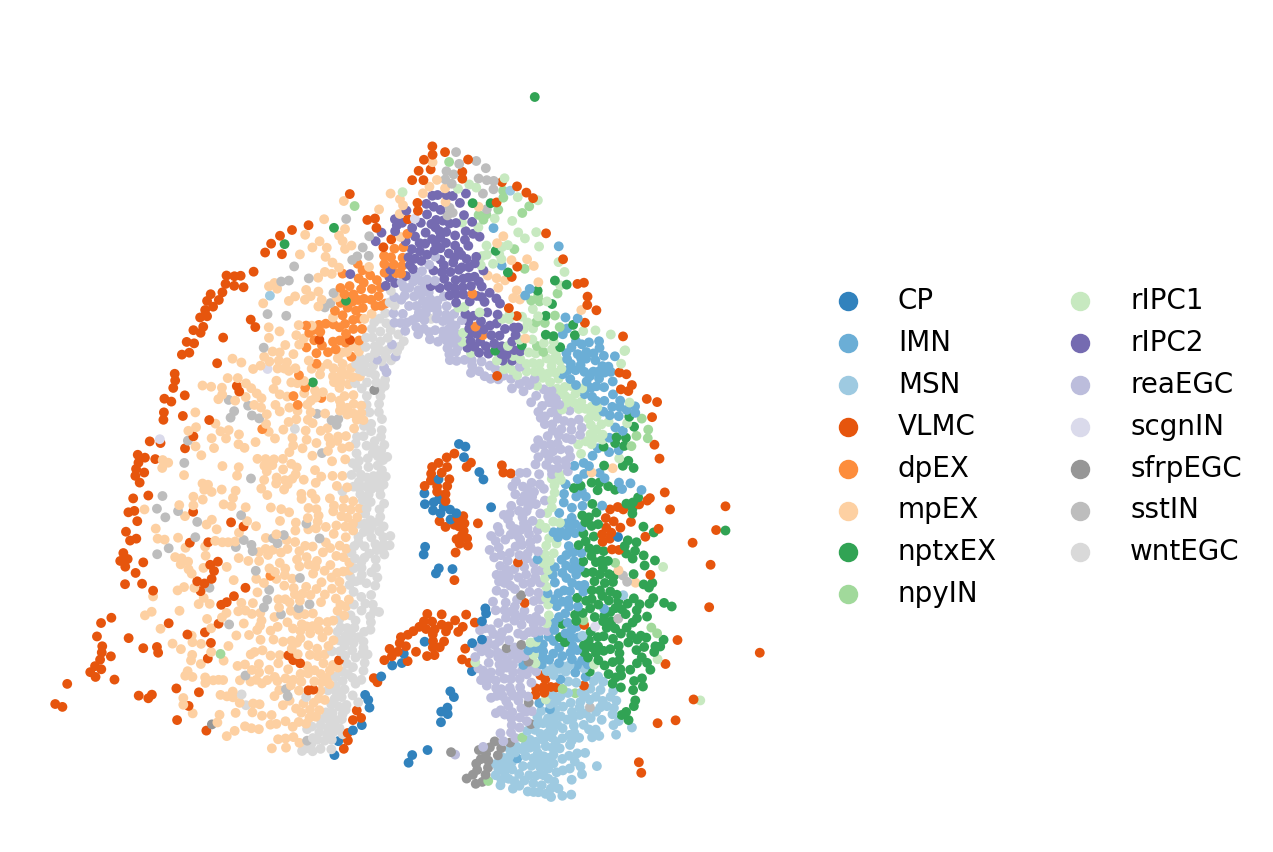

In [5]:
fig, axs = plt.subplots(figsize=(5, 5))
ax = sc.pl.embedding(adata,  basis='X_spatial',show=False,color='cluster',ax=axs,frameon=False,title=' ',palette='tab20c',size=50)


readEGC： reactive ependymoglial cells;  rIPC1：regeneration intermediate progenitor cells 1;  IMN：immature neuron;  nptxEX: Nptx+ lateral pallium excitatory neurons;  MSN：medium spiny  neuron;  sfrpEGC：sfrp+ ependymoglial cells;  CP：choroid plexus;  VLMC：vascular leptomeningeal cell;  wntEGC： Wnt+ EGC;  mpEX：medial pallium excitatory neuron;  sstIN：Sst+ inhibitory neuron;  scgnIN:Scgn+ inhibitory neuron;  dpEX：dorsal palliumexcitatory neuron;



## 2. Choose start cells

First,we should select starting cluster or specify a group of cells as the beiginning of trajectory. Users can provide a cluster name or a specific point by spatial coordinates or use lasso to circle cells. Determining start cell is a necessary and important step to infer trajectory by spaTrack. We suggest users know detail prior knowledge and powerful biological evidence to support the reliability of slecting start cells. Here, we manually set the reavtive EGC as starting cells, which have a positive role in axolotl brain regeneration stage and supprtted by prior knowledge. For identifying specific intersting regions exactly and conveniently, we manually set a specific point in reaEGC region and find its neighbor cells as start site and we also provide an interactive function to circle aimed region to obtain cell corrdiation.

### 2.1 select by coordinates

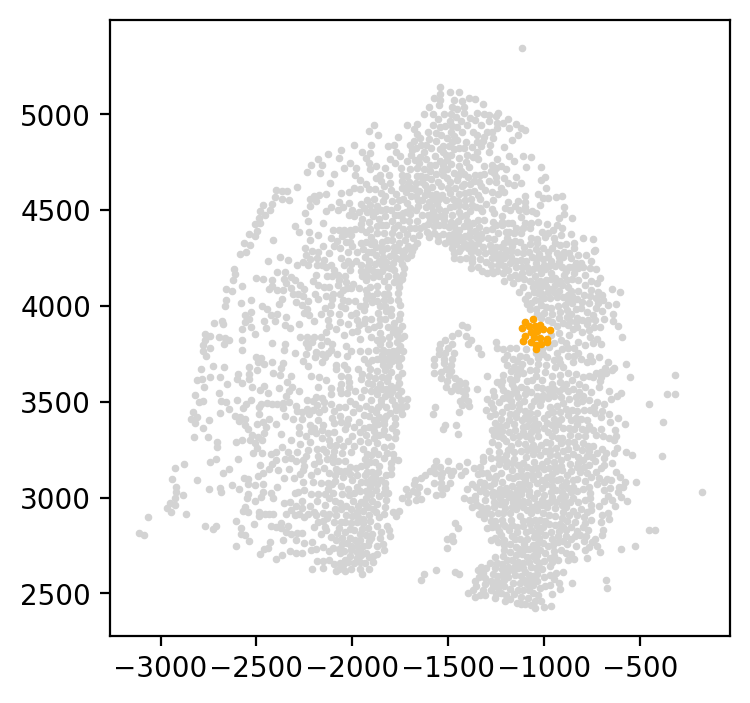

In [6]:
start_cells=spt.set_start_cells(adata,select_way='coordinates',cell_type='reaEGC',start_point=[-1050,3850],n_neigh=20)

fig, axs = plt.subplots(figsize=(4, 4))
plt.scatter(adata.obsm['X_spatial'][:,0],adata.obsm['X_spatial'][:,1],c='#D3D3D3',s=3)
plt.scatter(adata.obsm['X_spatial'][start_cells][:,0],adata.obsm['X_spatial'][start_cells][:,1],c='orange',s=3)

### 2.2 select by cell type

In [7]:
# start_cells=spt.set_start_cells(adata,select_way='cell_type',cell_type='reaEGC')

# fig, axs = plt.subplots(figsize=(4, 4))
# plt.scatter(adata.obsm['X_spatial'][:,0],adata.obsm['X_spatial'][:,1],c='#D3D3D3',s=3)
# plt.scatter(adata.obsm['X_spatial'][start_cells][:,0],adata.obsm['X_spatial'][start_cells][:,1],c='orange',s=3)

### 2.3 select by lasso

In [8]:
# L=spt.Lasso(adata)
# L.vi_plot(basis='spatial',cell_type='reaEGC')

In [9]:
# start_cells=L.sub_cells

# fig, axs = plt.subplots(figsize=(4, 4))
# plt.scatter(adata.obsm['X_spatial'][:,0],adata.obsm['X_spatial'][:,1],c='#D3D3D3',s=3)
# plt.scatter(adata.obsm['X_spatial'][start_cells][:,0],adata.obsm['X_spatial'][start_cells][:,1],c='orange',s=3)

## 3. Calculate cell transition probability

   Now, we start to calculate the trajectory velocity from spatial transcriptomics data.
   
   
   First, gene expression matrix (N x M，N is cell number; M is gene number)was inputted to calculate cell transition probability matrix (N x N) by the optiml transport theory. In axolotl brain spatial transcriptomics data, we setted data type is 'spatial' for utilizing cell spatial position information to obtain more reasonable cell transition probability.
   
<!--    Infer trajectory velocity and
cell transition probability matrix -->

In [10]:
adata.obsp['trans']=spt.get_ot_matrix(adata,data_type='spatial')

X_pca is not in adata.obsm, automatically do PCA first.


## 4. Caculate cell pseudotime

For each cell, calculate the sum of the probabilities of all initial cells transferring to that cell. Then sort all the cells according to the sum of transition probabilities from large to small, and give each cell a value between 0-1 as ptime in the form of an arithmetic sequence (the ptime of the cell with the largest sum of transition probabilities is 0, and the cell with the smallest is 1, the cells in the middle are incremented according to the sort order).

In [11]:
adata.obs['ptime']=spt.get_ptime(adata,start_cells)

## 5. Calculate vector field velocity.

Then, we should determine cell neighbor,which is important factor for cell velocity.Cell neighbor can be determined by cell spatial coordinates or PC1 and PC2 caculated by gene expression, corresponding to the  parameter of 'n_neigh_pos' and 'n_neigh_pca' respectively. The intersection of spatial coordinates neighbors and embedding matrix neighbors are used to determine cell neighbor.


For each cell, we take direction of the cell point to the neighbor as vector field speed direction (if neighbor cell pseudotime is larger than the cell,speed direction is reversed).After determining vector field speed direction, we use cell transition probability of the cell to its neighbors as conjunctive speed in vector field. Final velocity of the cell depends on the average conjunctive speed value to its neighboring cells.


   For presenting cell velocity streamline plot, we divide two-dimensional planes into 50x50 grids and converte cell velocity into grid velocity. And then select average speed of neighbor cells near grid point as the speed of grid point. Distance from the cell to the grid point determines the weight of cell speed, whcih  more closer to the grid point, the weight is more larger.

In [12]:
adata.uns['E_grid'],adata.uns['V_grid']=spt.get_velocity(adata,basis='spatial',n_neigh_pos=50)

## 6.Plot results

Here,the results value of start cells,cell  pseudotime and cell velocity results have been saved into adata. Users can visualize attented information from processed scanpy adata. we display pseudotime value distribution and cell trajectory plot.

<AxesSubplot: title={'center': 'ptime'}, xlabel='spatial1', ylabel='spatial2'>

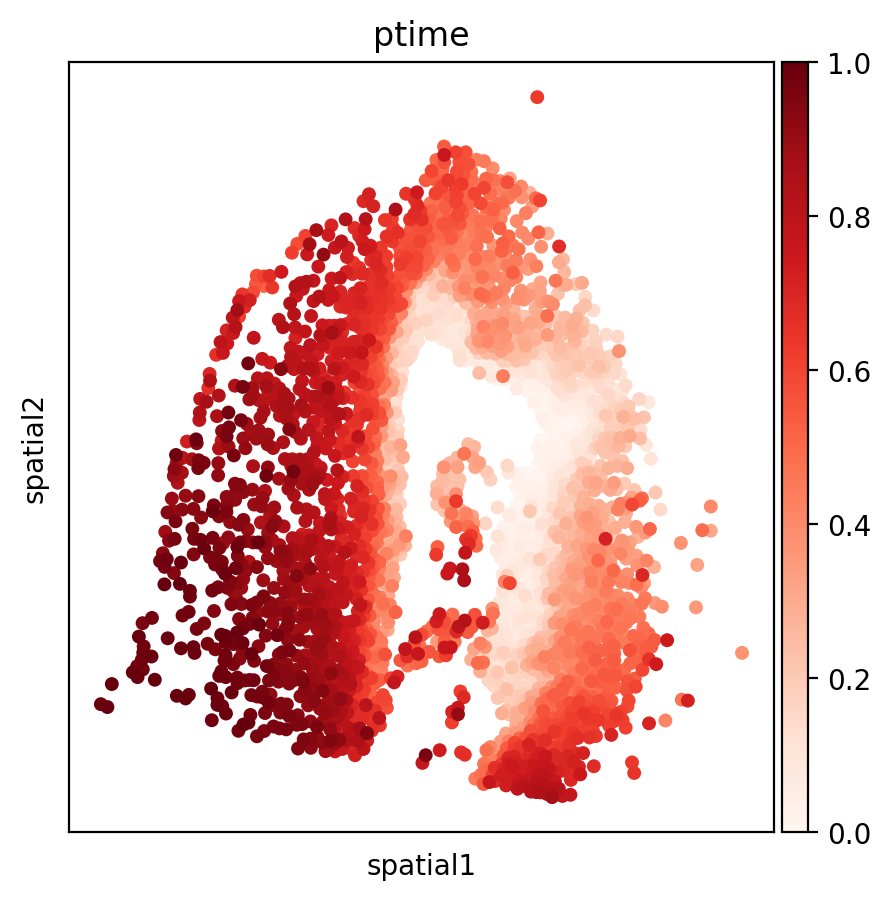

In [13]:
fig, axs = plt.subplots(figsize=(5, 5))
sc.pl.embedding(adata, basis='spatial', color='ptime', show=False, ax=axs, color_map='Reds', title='ptime',size=100)

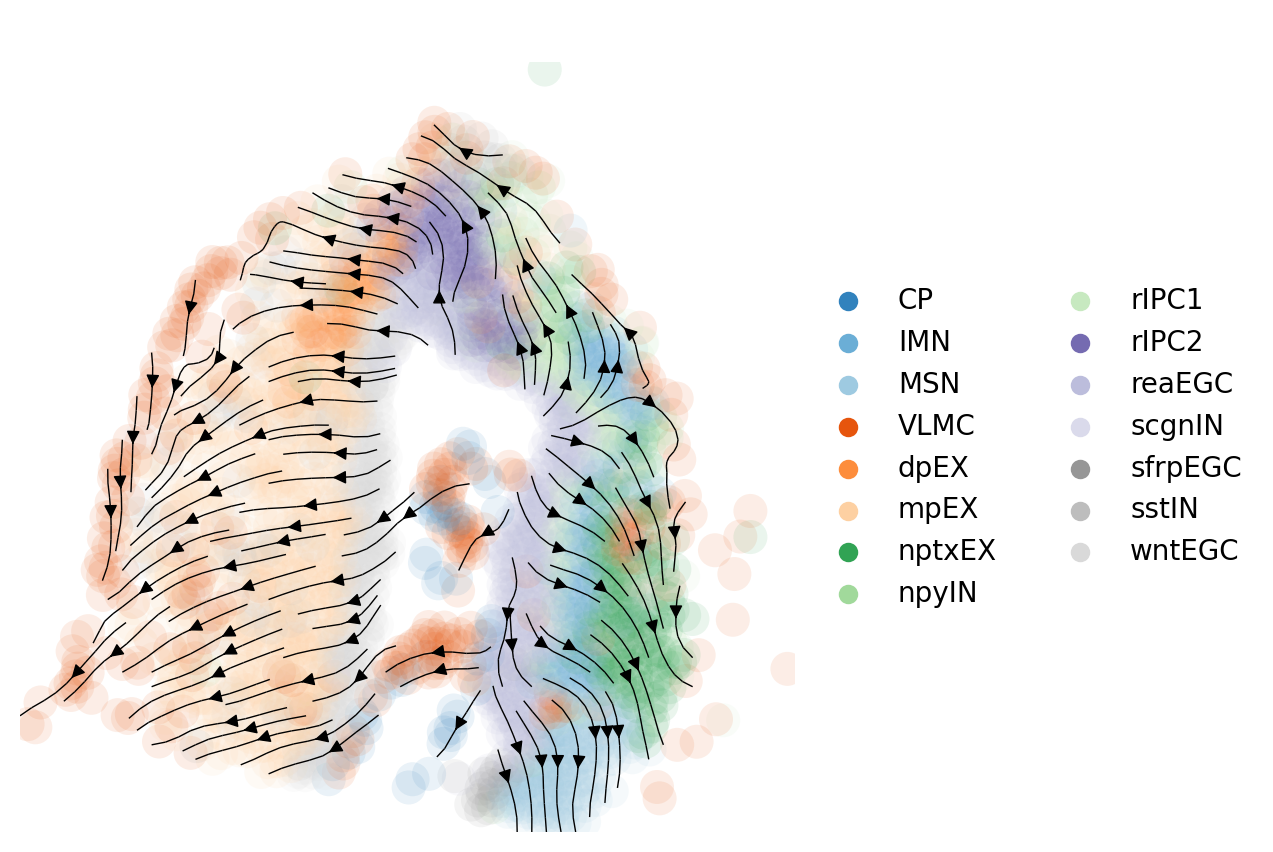

In [14]:
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(5,5))
ax = sc.pl.embedding(adata,  basis='spatial',show=False,title=' ',color='cluster',ax=axs,frameon=False,palette='tab20c',legend_fontweight='normal',alpha=0.1,size=600)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=1.8,color='black',linewidth=0.5,arrowsize=1,minlength=0.1,maxlength=0.4)

## 7. Downstream analysis

 After inferring starting cell differentiation trajectory, we foucs on a group of cell types in one trajectory branch axolotl play an important role in  brain regeneration after injury. we can predict the optimal transition path of cell fate transition and identify key drivers of cell-fate transitions in one trajectory branch. This demo part can be used to answer the biological question whcih genes drive cell-fate transitions along optimal transition path of cell trajectory.

### 7.1 Least Action Path (LAP)

In order to find the trajectory that best fits vector field and discard the disturbing of weakly correlated cells in trajectory ,we refine  the least action path method of dynamo[] to apply into spatial transcriptomics data.


LAP algorithm utilizes each cell velocity to infer optimal transition path, so,we need to reconstruct the grid level vector field into cell level. 



In [15]:
VecFld=spt.VectorField(adata,basis='spatial')

And then,users need specify a start point and an end point to infer trajectory's  LAP . Algorithm can automatically selects the nearest cells of specified point when there is no cell in specified X and Y coordinate.

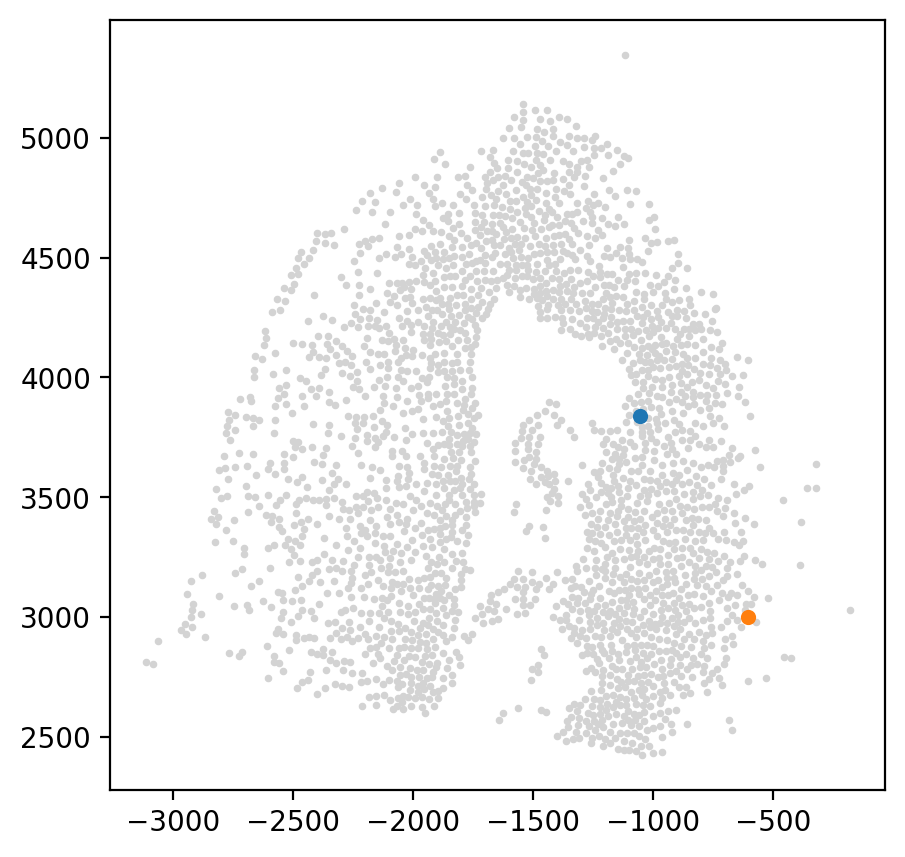

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

LAP_start_point=[-1050,3850]
LAP_end_point=[-625,3000]
LAP_start_cell=spt.nearest_neighbors(LAP_start_point,adata.obsm['X_spatial'])[0][0]
LAP_end_cell=spt.nearest_neighbors(LAP_end_point,adata.obsm['X_spatial'])[0][0]

plt.scatter(*adata.obsm["X_spatial"].T,c='#D3D3D3',s=3)
plt.scatter(*adata[LAP_start_cell].obsm['X_spatial'].T,s=20)
plt.scatter(*adata[LAP_end_cell].obsm['X_spatial'].T,s=20)

LAP can find an optimal path between the given starting(LAP_start_point)and end points (LAP_end_point). xpectation-Maximization algorithm search minimizing action and update optimal path, users can adjust the number of steps to obtain more smooth and optimal path (Least Action Path).

In [17]:
lap=spt.least_action(adata,
    init_cells=adata.obs_names[LAP_start_cell],
    target_cells=adata.obs_names[LAP_end_cell],
    vecfld=VecFld,
    basis='spatial',
    adj_key='X_spatial_distances',
    EM_steps=5,
    n_points=20
)

Next, in order to choose core cells along focused trajectory branch，we select neighbor cells around the least action path. And then map cells on LAP line to assign cells new pseudotime value.


Plot the least action Path 

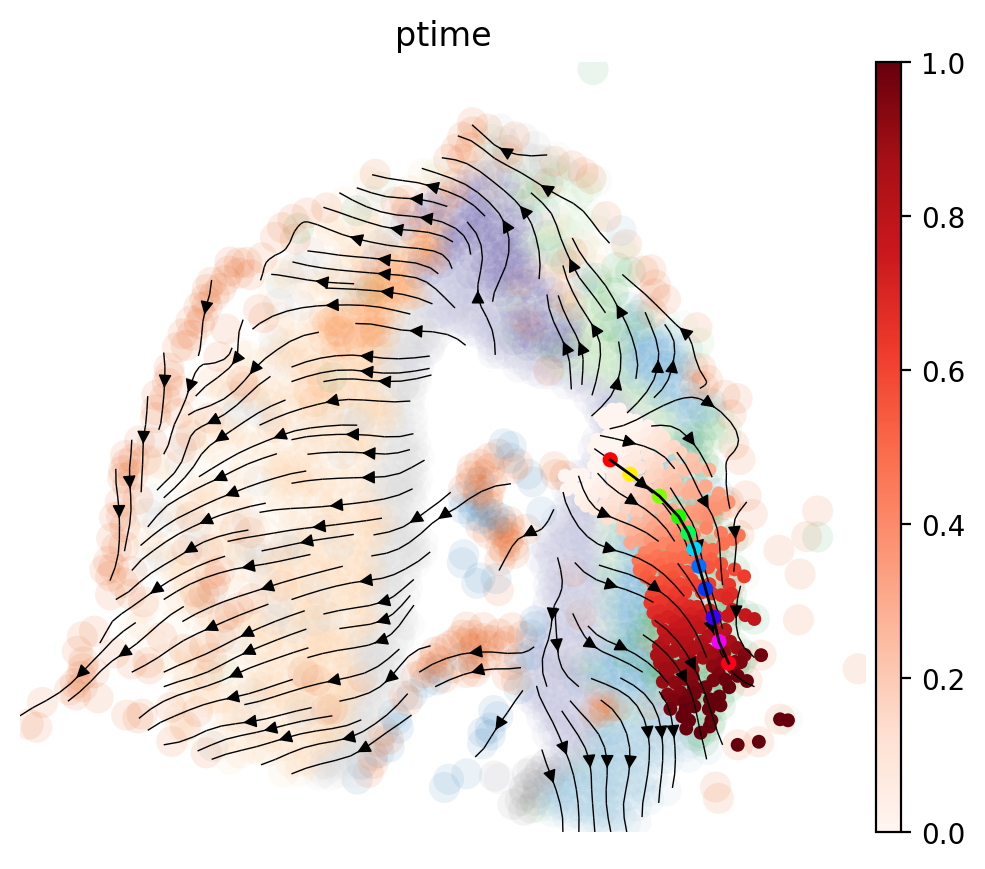

In [18]:
LAP_ptime,LAP_nbrs=spt.map_cell_to_LAP(adata,cell_neighbors=80)
sub_adata=adata[LAP_nbrs,:]
sub_adata.obs['ptime']=LAP_ptime
sub_adata=sub_adata[np.argsort(sub_adata.obs["ptime"].values), :].copy()

fig, ax = plt.subplots(figsize=(6,5))
plt.axis('off')
ax = sc.pl.embedding(adata,  basis='X_spatial',color='cluster',show=False,ax=ax,frameon=False,legend_loc=None,title=' ',alpha=0.1,size=500)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=1.8,color='black',linewidth=0.5,arrowsize=1,minlength=0.1,maxlength=0.4)
ax = spt.plot_least_action_path(adata,basis='spatial',ax=ax,point_size=20,linewidth=1)
sc.pl.embedding(sub_adata, basis='X_spatial',ax=ax, color="ptime", cmap="Reds",frameon=True,size=100)

###  7.2 pseudotime-dependent genes on LAP

After we obtain optimal transition path and cell pseudotime on optimal transition path, a common question which genes drive cell transition along optimal trajectory path can be answered by fit gene expression and cell pseudotime value with Generalized Additive Model（GAM).Significantly associated genes are called pseudotime-dependent genes.

First,we choose focused cell type on optimal transition path and filter genes with highly variable and larger than minimum expression proporation

In [19]:
sub_adata=sub_adata[sub_adata.obs['cluster'].isin(['reaEGC','rIPC1', 'IMN','nptxEX'])]
sub_adata=spt.filter_gene(sub_adata,min_exp_prop=0.2,hvg_gene=2000)

cluter ordered by ptime :  ['reaEGC', 'rIPC1', 'IMN', 'nptxEX']
Cell number	251
Gene number	371


Then, we fit gene expression and corresponding cell pseudotime by Generalized Additive Model. Pseudotime-dependent genes were filtered by the degree of model fit and FDR. For friendly visualizing pseudotime-dependent genes across trajectory, we splitted cell ordered by pseudotime into windows and rank gene by maximum expression window order number.

In [20]:
df_res  = spt.ptime_gene_GAM(sub_adata,core_number=5)
df_sig_res = df_res.loc[(df_res['model_fit']>0.1) & (df_res['fdr']<0.05)]

Genes number fitted by GAM model:   371


Finally selected 75 genes.


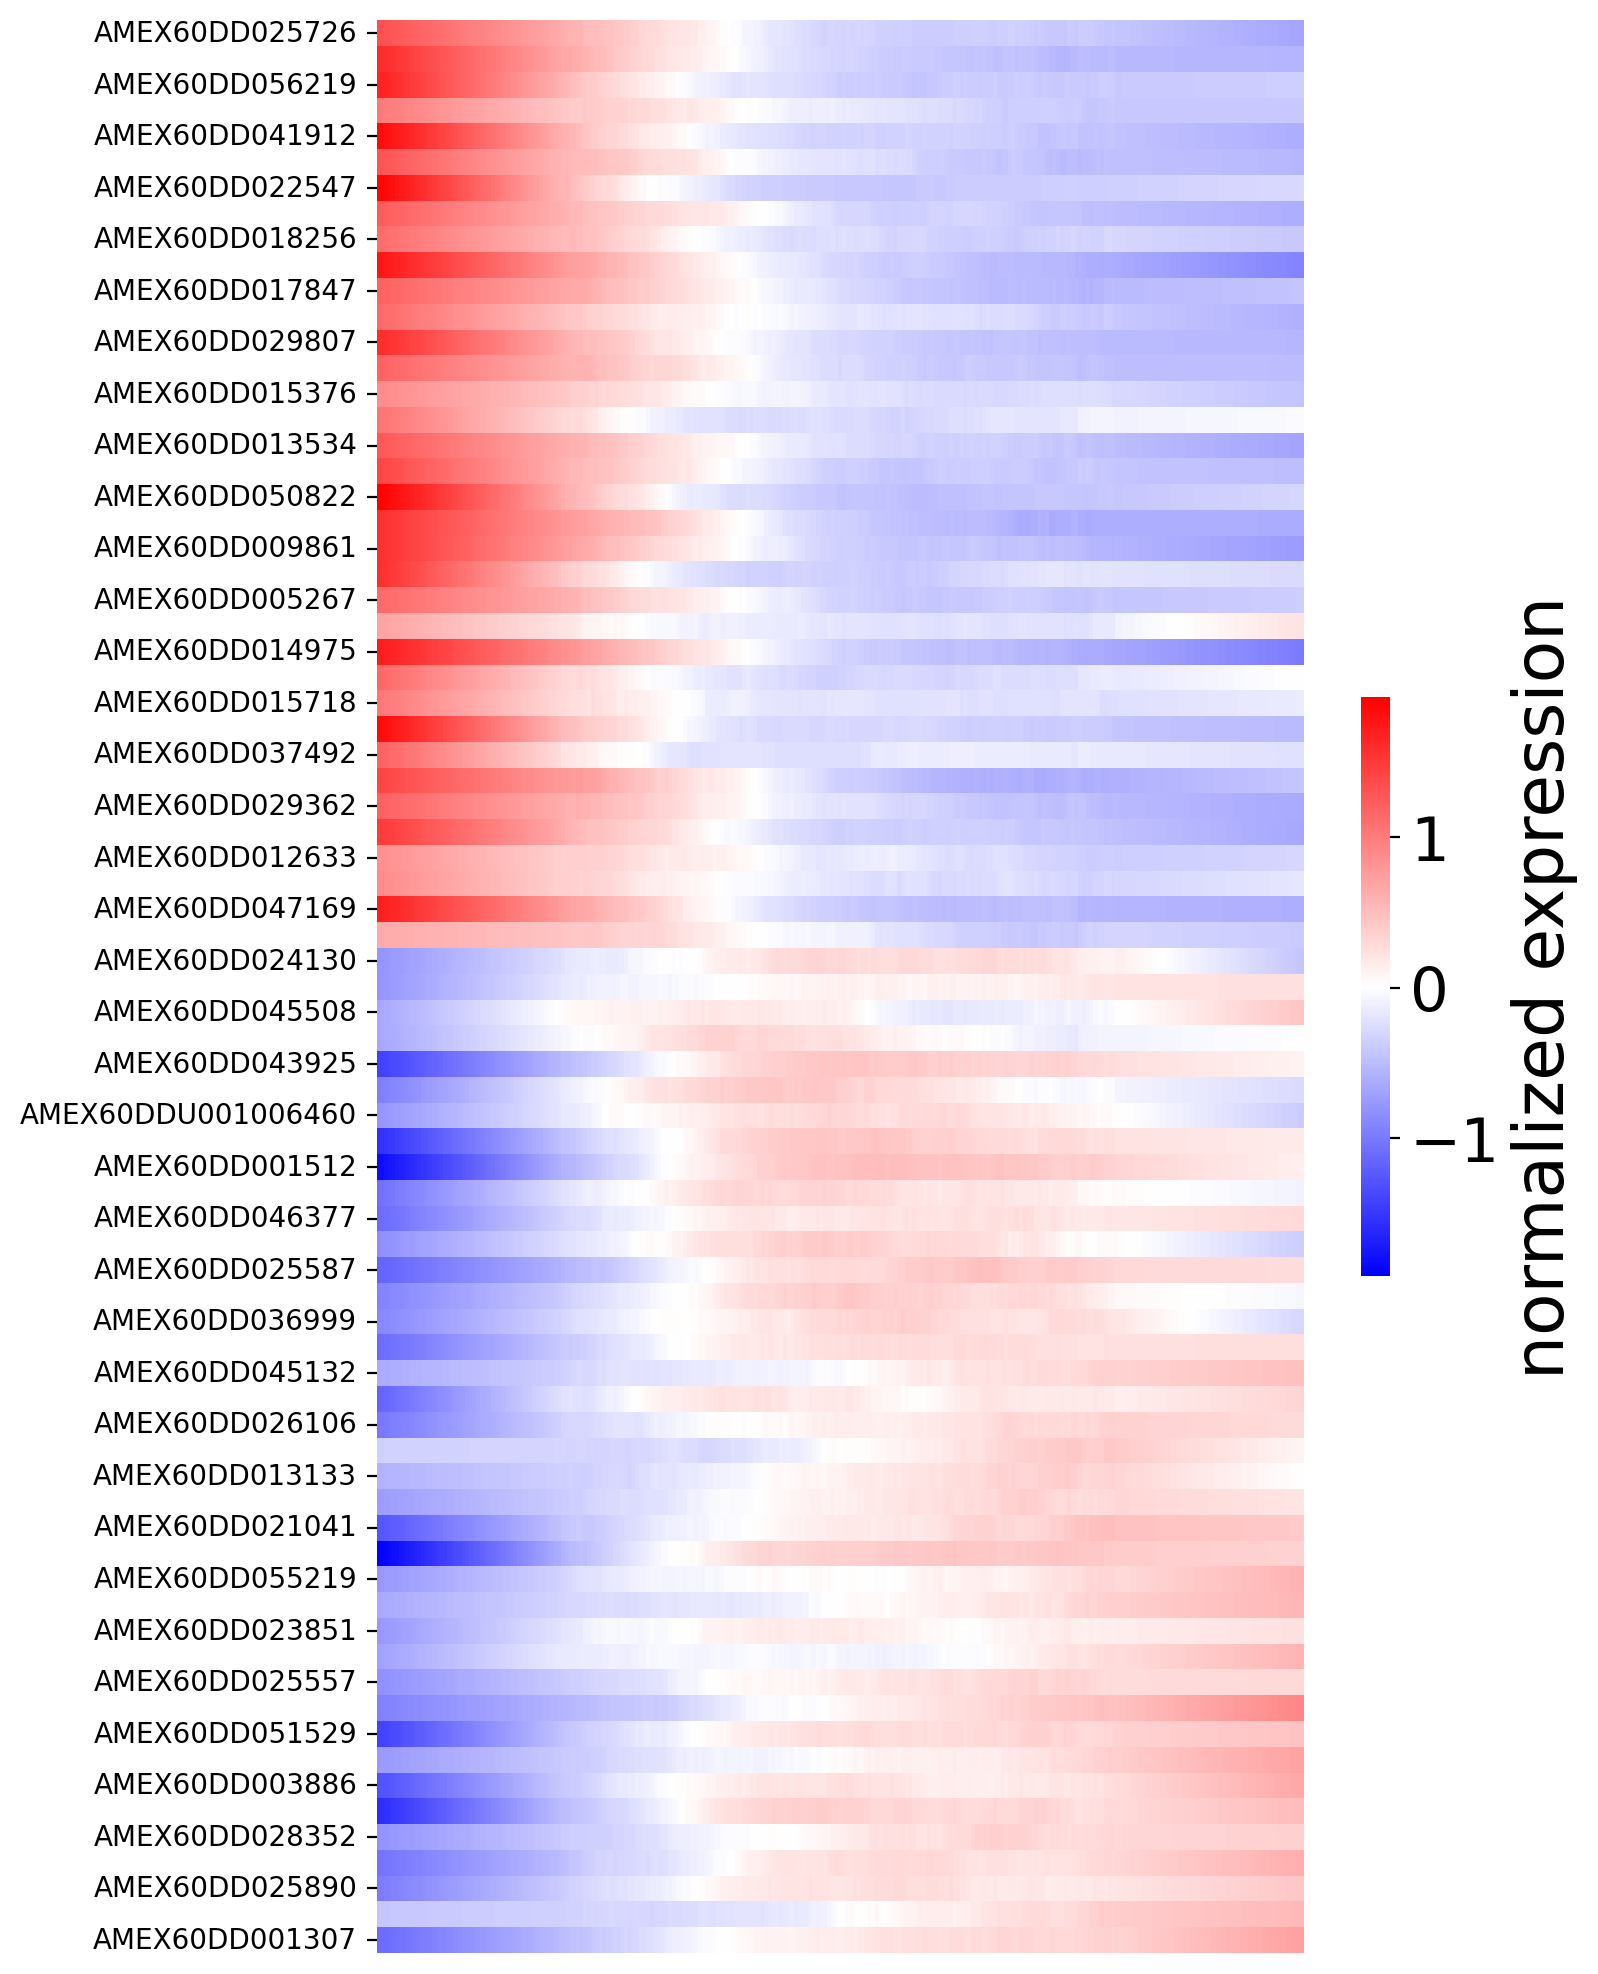

In [21]:
sort_exp_sig = spt.order_trajectory_genes(sub_adata,df_sig_res,cell_number=20)
spt.plot_trajectory_gene_heatmap(sort_exp_sig,smooth_length=100,gene_label_size=10,cmap_name='bwr')

Displaying the expression of a single key gene along ptimes.

<AxesSubplot: title={'center': 'AMEX60DD008266'}, xlabel='ptime', ylabel='expression'>

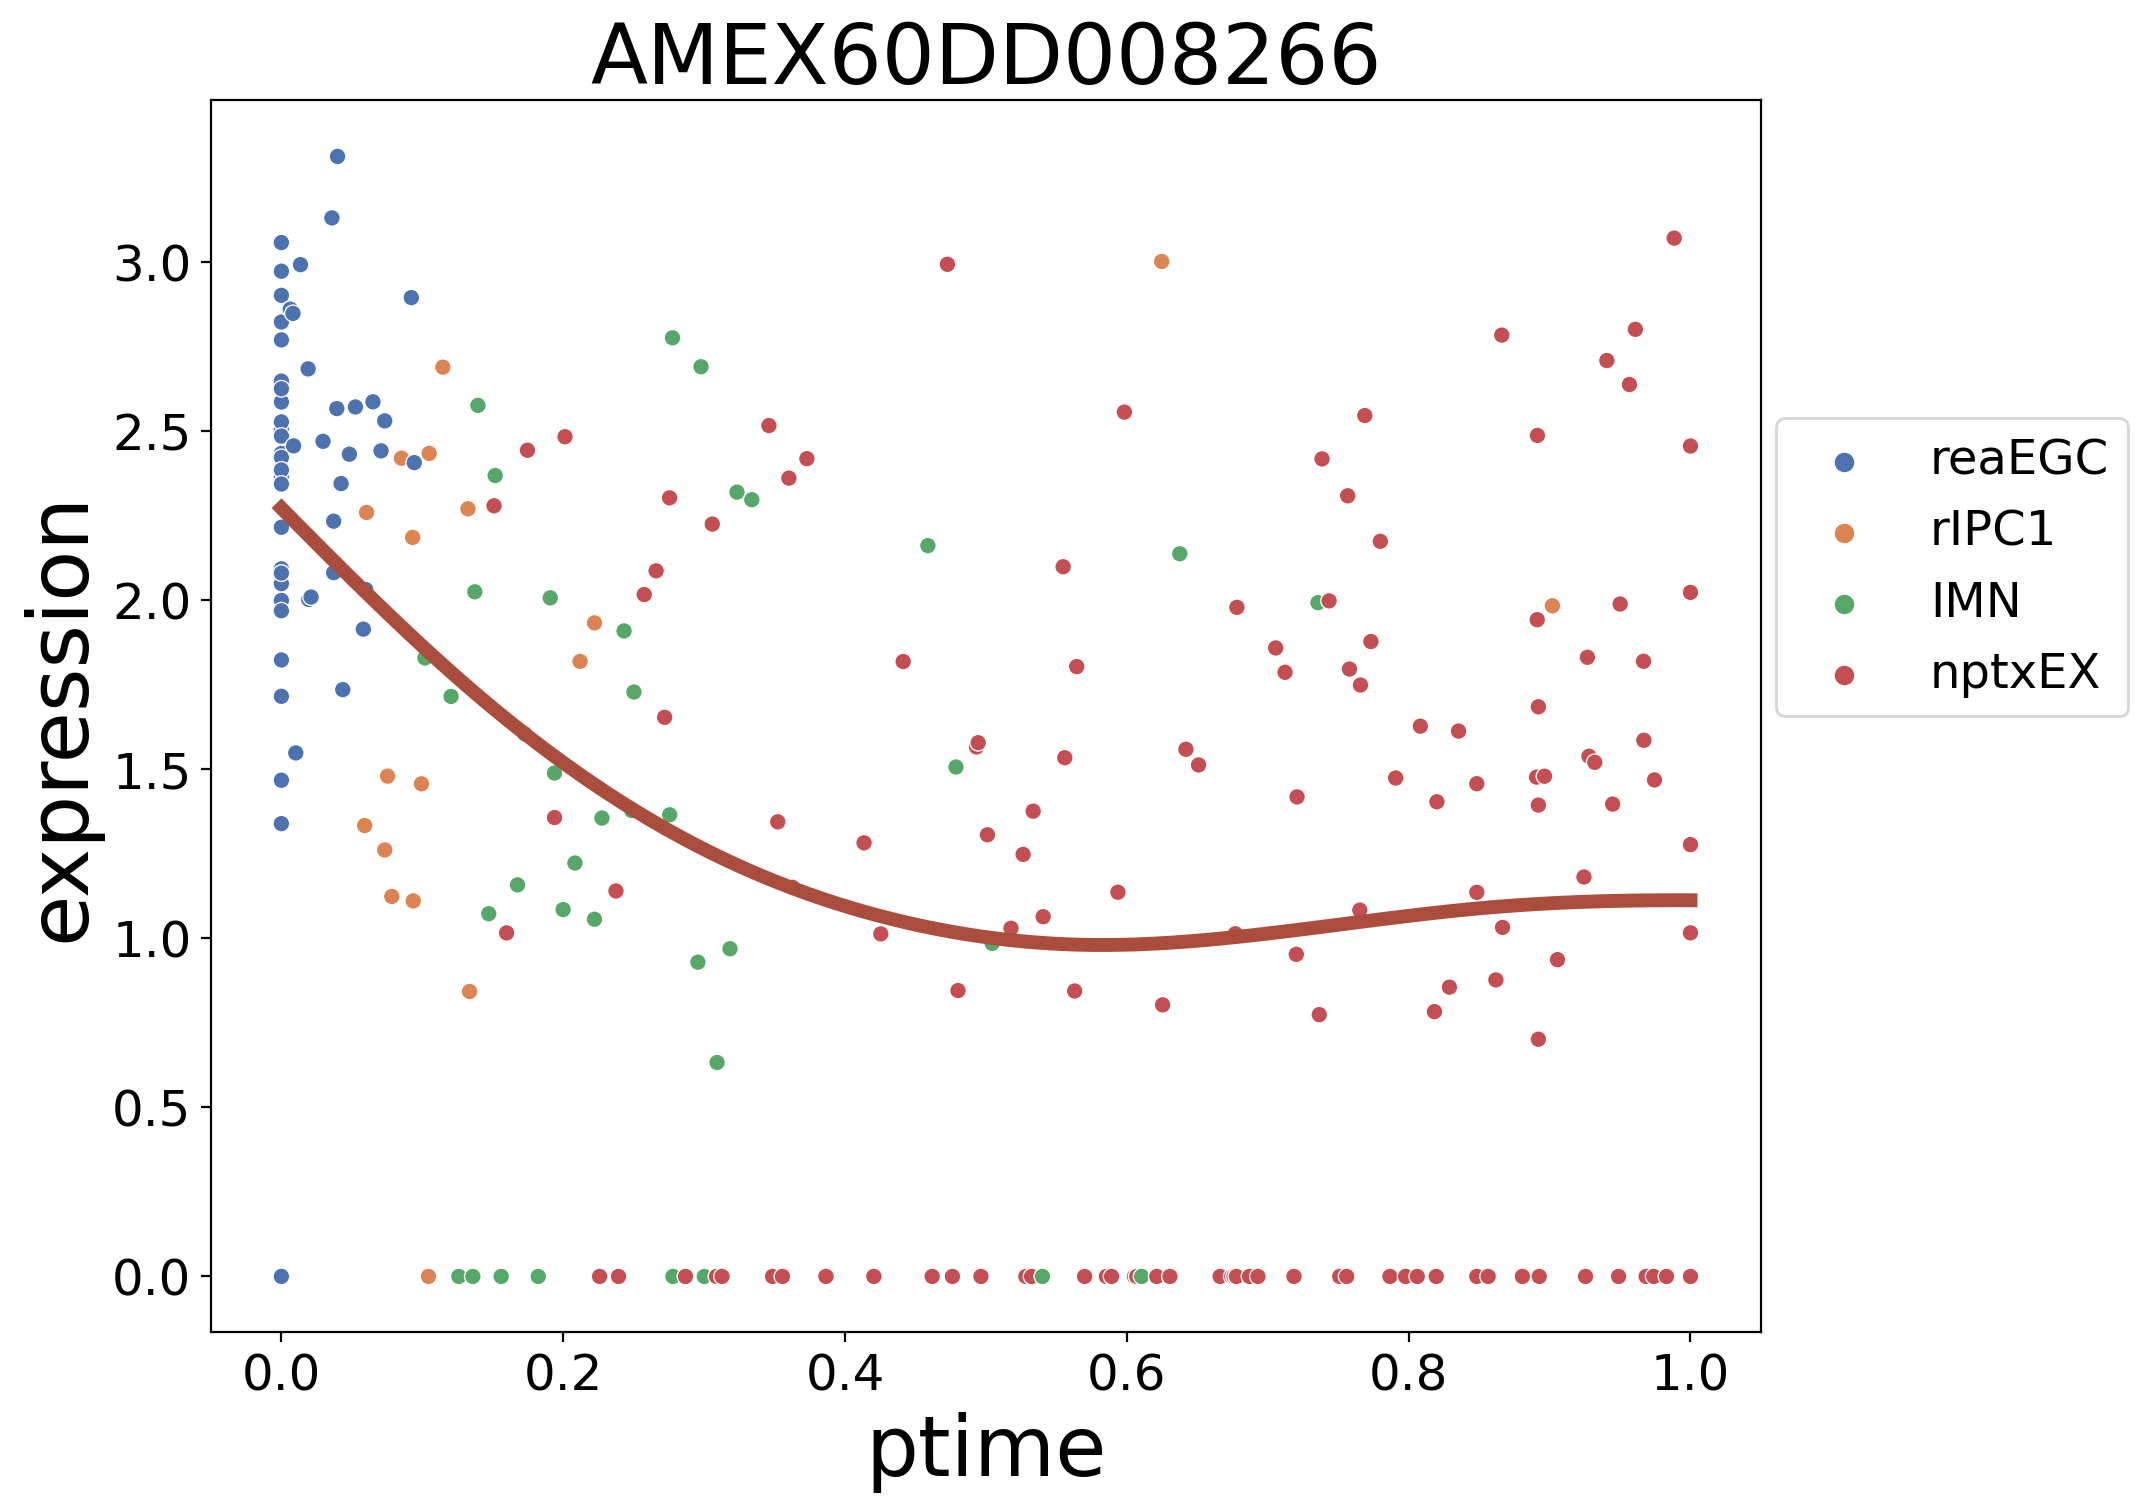

In [22]:
spt.plot_trajectory_gene(sub_adata,gene_name='AMEX60DD008266',show_cell_type=True)